# Forecasting Retail Sales using Time Series Models.


DESCRIPTION:
The objective of this project is to develop a robust time series forecasting model that can accurately predict the unit sales for various items sold in Favorita stores. Favorita is a leading grocery retailer based in Ecuador, and the company's sales data will be used to build the model. The data set contains sales data for thousands of items sold at different stores, making it a challenging and complex problem.

To build an accurate forecasting model, various statistical and machine learning techniques will be used. The data will be preprocessed to ensure that it is clean, consistent, and in the right format for analysis. Exploratory data analysis (EDA) techniques will be employed to gain a deeper understanding of the data and identify any patterns or trends in the sales data.

Time series forecasting models, such as ARIMA, Linear regression and a few others will be used to predict store sales. These models will be trained using historical sales data, and their accuracy will be evaluated using various performance metrics such as root mean square logarithmic error, root mean squared error (RMSE), and mean square error (MSE).

The results obtained from the forecasting models will be analyzed, and insights gained from the analysis will be used to make informed business decisions. The insights could include identifying which products have high demand at different times of the year, which stores perform better than others, and identifying any trends in sales data that could inform marketing and inventory decisions.

Overall, the project aims to build a reliable time series forecasting model that can help Favorita optimize their sales strategies and improve their bottom line.

## Hypothesis

##### ALTENATE HYPOTHESIS: Average sales of a product family at a specific store is 500 

#####  ALTENATE HYPOTHESIS: Average sales of product family differ between store 1 and store 2 

##### ALTENATE Hypothesis: There is a significant difference in sales before and after promotion 

##### ALTENATE  Hypothesis: Promotion and sales outcomes are associated

##### ALTERNATE Hypothesis: The average sales of product family X differ between store Y1 and store Y2. 

## Questions

Is the train dataset complete (has all the required dates)?

Which dates have the lowest and highest sales for each year?

Did the earthquake impact sales?

Are certain groups of stores selling more products? (Cluster, city, state, type)

Are sales affected by promotions, oil prices and holidays?

What analysis can we get from the date and its extractable features?

What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)


### Data Importation
The project starts by importing necessary libraries and environment variables from the '.env' file. It then establishes a connection to the SQL Server using the provided credentials and loads data from three tables: 'dbo.oil', 'dbo.holidays_events', and 'dbo.stores'. Additionally, data from two local CSV files, 'sample_submission.csv' and 'test.csv', is imported using pandas. Lastly, data from a zip file, 'train.csv' and 'transactions.csv', is loaded into the DataFrame 'df_train' and 'df_transactions', respectively.

In [1]:
### Data importation
#pip install pyodbc
#pip install sqlalchemy
#pip install lightgbm
#pip install catboost
#pip install python-dotenv

In [126]:
# Libraries Importation
import pyodbc
import sqlalchemy as sa
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from dotenv import dotenv_values
from scipy import stats
import calendar
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

In [4]:
# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("database")
server = environment_variables.get("server")
username = environment_variables.get("username")
password = environment_variables.get("password")

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

conn = pyodbc.connect(connection_string)

In [5]:
#define the tables
table1 = 'dbo.oil'
table2 = 'dbo.holidays_events'
table3 = 'dbo.stores'

In [6]:
#creating  query to select the tables to be imported
query1 = f"SELECT * FROM {table1}"
df_oil = pd.read_sql(query1, conn)

query2 = f"SELECT * FROM {table2}"
df_holidays_events = pd.read_sql(query2, conn)

query3 = f"SELECT * FROM {table3}"
df_stores= pd.read_sql(query3, conn)

In [7]:
#close the connection
conn.close()

In [8]:
#importing local csv data
df_sample_submission=pd.read_csv('../Regression_Time_Series/Assets/sample_submission.csv')
df_test=pd.read_csv('../Regression_Time_Series/Assets/test.csv')

with zipfile.ZipFile('../Regression_Time_Series/Assets/trai&transactions.zip', 'r') as zip_ref:
    # Read the contents of the zip file
    with zip_ref.open('train.csv') as file_train:
        df_train = pd.read_csv(file_train)

    with zip_ref.open('transactions.csv') as file_transactions:
        df_transactions = pd.read_csv(file_transactions)


### Data Preparation

#### Oil Prices
The 'df_oil' DataFrame contains daily oil price data.
(Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)
The following data preparation steps are performed:

-Check for missing values, resulting in finding one missing value in the 'dcoilwtico' column.

-Fill the missing value using the forward-fill method to propagate the last valid observation forward.

-Convert the 'date' column to datetime format.
Extracted additional date features like 'year', 'month', 'day', and 'day_of_week'.

-Checked for duplicate rows and found none, so no duplicate rows were dropped.

-Checked for zero or negative oil prices and found none. No rows were removed or replaced.


In [9]:
df_oil


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
...,...,...
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999


In [10]:
# Check for missing values in df_oil
print(df_oil.isnull().sum())


date           0
dcoilwtico    43
dtype: int64


In [11]:
# Fill missing values using forward-fill method
df_oil.fillna(method='ffill', inplace=True)

# Verify if there are any missing values after filling
print(df_oil.isnull().sum())


date          0
dcoilwtico    1
dtype: int64


In [12]:

# Drop rows with missing values in 'dcoilwtico' column
df_oil.dropna(subset=['dcoilwtico'], inplace=True)

# Verify if there are any missing values after filling
print(df_oil.isnull().sum())



date          0
dcoilwtico    0
dtype: int64


In [13]:
# Convert 'date' column to datetime format
df_oil['date'] = pd.to_datetime(df_oil['date'])


In [14]:
# Extract additional date features
df_oil['year'] = df_oil['date'].dt.year
df_oil['month'] = df_oil['date'].dt.month
df_oil['day'] = df_oil['date'].dt.day
df_oil['day_of_week'] = df_oil['date'].dt.dayofweek


In [15]:
# Check data types of columns in df_oil
print(df_oil.dtypes)


date           datetime64[ns]
dcoilwtico            float64
year                    int64
month                   int64
day                     int64
day_of_week             int64
dtype: object


In [16]:
# Check for duplicate rows in df_oil
duplicate_rows = df_oil[df_oil.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

# Drop duplicate rows if needed
df_oil.drop_duplicates(inplace=True)


Number of duplicate rows: 0


In [17]:
# Check for zero or negative oil prices
invalid_prices = df_oil[df_oil['dcoilwtico'] <= 0]
print("Number of rows with zero or negative oil prices:", invalid_prices.shape[0])

# Replace or remove rows with zero or negative oil prices 

mean_oil_price = df_oil[df_oil['dcoilwtico'] > 0]['dcoilwtico'].mean()
df_oil.loc[df_oil['dcoilwtico'] <= 0, 'dcoilwtico'] = mean_oil_price


Number of rows with zero or negative oil prices: 0


In [18]:
# checking for seasonal decomposition using statsmodels library

# 'date' is set as the index of df_oil
result = seasonal_decompose(df_oil['dcoilwtico'], model='additive', period=365)
trend = result.trend
seasonal = result.seasonal
residual = result.resid



#### Holiday Events
The 'df_holidays_events' DataFrame contains holidays and events data

Check for missing values.
Convert the 'date' column to datetime format.
Extract additional date features like 'year', 'month', 'day', and 'day_of_week'.
Check for duplicate rows.
Handle any necessary cleaning or adjustments specific to this DataFrame.

In [19]:
df_holidays_events


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [20]:
# Check for missing values in df_holidays_events
df_holidays_events.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [21]:
# Convert 'date' column to datetime format
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])

In [22]:
# Extract additional date features
df_holidays_events['year'] = df_holidays_events['date'].dt.year
df_holidays_events['month'] = df_holidays_events['date'].dt.month
df_holidays_events['day'] = df_holidays_events['date'].dt.day
df_holidays_events['day_of_week'] = df_holidays_events['date'].dt.dayofweek

In [23]:
# Check for duplicate rows in df_holidays_events
duplicate_rows = df_holidays_events[df_holidays_events.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])


Number of duplicate rows: 0


In [24]:
# Filter holidays with 'type' as 'Transfer'
transfer_holidays = df_holidays_events[df_holidays_events['type'] == 'Transfer']

# Display the holidays with 'type' as 'Transfer'
transfer_holidays


,date,type,locale,locale_name,description,transferred,year,month,day,day_of_week
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,2012,10,12,4
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,2013,10,11,4
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,2014,10,10,4
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False,2016,5,27,4
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False,2016,7,24,6
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False,2016,8,12,4
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False,2017,1,2,0
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False,2017,4,13,3
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False,2017,5,26,4
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False,2017,8,11,4


The code below defines a function 'handle_transferred_holidays' to adjust the holiday dates for transferred holidays. It checks if a holiday is transferred (True), then finds the corresponding row where the 'type' is 'Transfer' and the 'description' matches, and retrieves the transfer date. The adjusted date is then updated in the 'date' column. The 'transferred' column is dropped as it is no longer needed.

In [25]:
# Function to handle transferred holidays
def handle_transferred_holidays(row):
    if row['type'] == 'Transfer':
        corresponding_row = df_holidays_events[(df_holidays_events['description'] == row['description']) & 
                                               (df_holidays_events['type'] != 'Transfer') & 
                                               (df_holidays_events['date'] != row['date'])]
        if not corresponding_row.empty:
            return corresponding_row.iloc[0]['date']
    return row['date']

# Apply the function to update the date for transferred holidays
df_holidays_events['date'] = df_holidays_events.apply(handle_transferred_holidays, axis=1)

# Update the additional date features after handling transferred holidays
df_holidays_events['year'] = df_holidays_events['date'].dt.year
df_holidays_events['month'] = df_holidays_events['date'].dt.month
df_holidays_events['day'] = df_holidays_events['date'].dt.day
df_holidays_events['day_of_week'] = df_holidays_events['date'].dt.dayofweek

# Drop any duplicate rows created after handling transferred holidays
df_holidays_events.drop_duplicates(inplace=True)

# Print the first few rows of df_holidays_events after handling transferred holidays
df_holidays_events.head()


,date,type,locale,locale_name,description,transferred,year,month,day,day_of_week
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,2,4
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,1,6
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,12,3
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,14,5
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,21,5


#### Stores

For data preparation on the df_stores DataFrame, we need to ensure that the data is cleaned, consistent, and in the right format for further analysis. 
Steps:
We will first check if there are any missing values in the DataFrame.
Ensure that the data types of columns are appropriate. For example, the 'cluster' column should be categorical, and the 'store_nbr' column should be an integer.
Remove any columns that are not needed for our analysis or modeling.
If there are any relevant features that can be extracted from existing columns, we will create them to help with analysis or modeling.

In [26]:
df_stores


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [27]:
# Check for Missing Values
df_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [28]:
# Data Types
df_stores['type'] = df_stores['type'].astype('category')
df_stores['city'] = df_stores['city'].astype('category')
df_stores['state'] = df_stores['state'].astype('category')
df_stores['cluster'] = df_stores['cluster'].astype('category')

In [29]:
# Check for missing values in df_stores
df_stores.isnull().sum()


store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [30]:
# Verify the changes
df_stores.dtypes

store_nbr       int64
city         category
state        category
type         category
cluster      category
dtype: object

#### Sample Submission
Since this is not part of the training data or directly used for modeling, there won't be any data preparation steps.


In [31]:
df_sample_submission


,version https://git-lfs.github.com/spec/v1
0,oid sha256:17505ec561d9bc64a3c10c3eb00474becf1...
1,size 342153


#### Transactions
Data preparation for the df_transactions DataFrame involves cleaning and organizing the transaction data before using it in the time series forecasting model. The df_transactions DataFrame contains information about transactions made on specific dates in various stores. 
Steps
-Check for Missing Values
-Convert 'date' Column to Datetime Format
-Extract Additional Date Features
-Check Data Types




In [32]:
df_transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [33]:
df_transactions.isnull().sum()


date            0
store_nbr       0
transactions    0
dtype: int64

In [34]:
df_transactions['date'] = pd.to_datetime(df_transactions['date'])


In [35]:
df_transactions['year'] = df_transactions['date'].dt.year
df_transactions['month'] = df_transactions['date'].dt.month
df_transactions['day'] = df_transactions['date'].dt.day
df_transactions['day_of_week'] = df_transactions['date'].dt.dayofweek


In [36]:
df_transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
year            0
month           0
day             0
day_of_week     0
dtype: int64

In [37]:
df_transactions.dtypes


date            datetime64[ns]
store_nbr                int64
transactions             int64
year                     int64
month                    int64
day                      int64
day_of_week              int64
dtype: object

In [38]:
duplicate_rows = df_transactions[df_transactions.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

# Drop duplicate rows if needed
df_transactions.drop_duplicates(inplace=True)


Number of duplicate rows: 0


##### Train Data
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

In [39]:
df_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [40]:
# Convert 'date' column to datetime data type in df_train
df_train['date'] = pd.to_datetime(df_train['date'])

In [41]:
# Extract additional date features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek


In [42]:
df_train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
day            0
day_of_week    0
dtype: int64

#### Merging


In [43]:
# Check data types of 'date' column in both dataframes
#print(df_train['date'].dtype)
#print(df_holidays_events['date'].dtype)


In [86]:
# Merge dataframes using inner join to avoid missing values
# Merge dataframes using inner join to avoid missing values
train_df = df_train.merge(df_stores, on='store_nbr', how='inner')
train_df = train_df.merge(df_holidays_events, on='date', how='inner')
train_df = train_df.merge(df_oil, on='date', how='inner')
train_df = train_df.merge(df_transactions, on=['date', 'store_nbr'], how='inner')

# Display the first few rows of the merged dataframe
#merged_data = df_train

train_df.head()



,id,date,store_nbr,family,sales,onpromotion,year_x,month_x,day_x,day_of_week_x,...,dcoilwtico,year_x,month_x,day_x,day_of_week_x,transactions,year_y,month_y,day_y,day_of_week_y
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,2013,2,11,0,...,97.010002,2013,2,11,0,396,2013,2,11,0
1,73063,2013-02-11,1,BABY CARE,0.0,0,2013,2,11,0,...,97.010002,2013,2,11,0,396,2013,2,11,0
2,73064,2013-02-11,1,BEAUTY,0.0,0,2013,2,11,0,...,97.010002,2013,2,11,0,396,2013,2,11,0
3,73065,2013-02-11,1,BEVERAGES,172.0,0,2013,2,11,0,...,97.010002,2013,2,11,0,396,2013,2,11,0
4,73066,2013-02-11,1,BOOKS,0.0,0,2013,2,11,0,...,97.010002,2013,2,11,0,396,2013,2,11,0


In [87]:
train_df.isnull().sum()

id               0
date             0
store_nbr        0
family           0
sales            0
onpromotion      0
year_x           0
month_x          0
day_x            0
day_of_week_x    0
city             0
state            0
type_x           0
cluster          0
type_y           0
locale           0
locale_name      0
description      0
transferred      0
year_y           0
month_y          0
day_y            0
day_of_week_y    0
dcoilwtico       0
year_x           0
month_x          0
day_x            0
day_of_week_x    0
transactions     0
year_y           0
month_y          0
day_y            0
day_of_week_y    0
dtype: int64

### Exploratory Data Analysis (EDA)

The next step in the project is to perform Exploratory Data Analysis (EDA) to gain insights into the data, understand its characteristics, and identify any patterns or trends that could influence the sales forecasting process. This will involve visualizations, summary statistics, and other analytical techniques to explore the data.

As part of EDA, we will:

Visualize the distribution of sales and other relevant variables.
Explore the relationship between sales and external factors like oil prices and holidays/events.
Analyze sales patterns over time, including seasonality and trends.
Examine correlations between different features to understand their interrelationships.
For example, we can plot sales over time to see if there are any recurring patterns, check if sales increase or decrease during specific months or years, and investigate whether there are any spikes in sales during holidays or promotions.

In [88]:
# Let's start by understanding the basic statistics and structure of the data.
train_df.head()
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320265 entries, 0 to 320264
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             320265 non-null  int64         
 1   date           320265 non-null  datetime64[ns]
 2   store_nbr      320265 non-null  int64         
 3   family         320265 non-null  object        
 4   sales          320265 non-null  float64       
 5   onpromotion    320265 non-null  int64         
 6   year_x         320265 non-null  int64         
 7   month_x        320265 non-null  int64         
 8   day_x          320265 non-null  int64         
 9   day_of_week_x  320265 non-null  int64         
 10  city           320265 non-null  category      
 11  state          320265 non-null  category      
 12  type_x         320265 non-null  category      
 13  cluster        320265 non-null  category      
 14  type_y         320265 non-null  object        
 15  

,id,store_nbr,sales,onpromotion,year_x,month_x,day_x,day_of_week_x,year_y,month_y,...,dcoilwtico,year_x,month_x,day_x,day_of_week_x,transactions,year_y,month_y,day_y,day_of_week_y
count,3.202650e+05,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,...,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000,320265.000000
mean,1.677167e+06,26.994642,406.335473,3.715979,2015.012571,7.408655,14.722308,1.990520,2015.012571,7.408655,...,63.740508,2015.012571,7.408655,14.722308,1.990520,1734.336321,2015.012571,7.408655,14.722308,1.990520
std,7.840547e+05,15.597233,1247.510221,15.515838,1.248534,3.241214,9.218841,1.496112,1.248534,3.241214,...,24.897165,1.248534,3.241214,9.218841,1.496112,1050.969397,1.248534,3.241214,9.218841,1.496112
min,7.306200e+04,1.000000,0.000000,0.000000,2013.000000,1.000000,1.000000,0.000000,2013.000000,1.000000,...,27.959999,2013.000000,1.000000,1.000000,0.000000,54.000000,2013.000000,1.000000,1.000000,0.000000
25%,9.870380e+05,13.000000,1.000000,0.000000,2014.000000,5.000000,6.000000,1.000000,2014.000000,5.000000,...,44.750000,2014.000000,5.000000,6.000000,1.000000,1030.000000,2014.000000,5.000000,6.000000,1.000000
50%,1.841515e+06,27.000000,19.000000,0.000000,2015.000000,7.000000,12.000000,2.000000,2015.000000,7.000000,...,51.980000,2015.000000,7.000000,12.000000,2.000000,1409.000000,2015.000000,7.000000,12.000000,2.000000
75%,2.208219e+06,40.000000,241.522000,1.000000,2016.000000,11.000000,24.000000,3.000000,2016.000000,11.000000,...,94.250000,2016.000000,11.000000,24.000000,3.000000,2149.000000,2016.000000,11.000000,24.000000,3.000000
max,3.000887e+06,54.000000,124717.000000,716.000000,2017.000000,12.000000,31.000000,4.000000,2017.000000,12.000000,...,107.949997,2017.000000,12.000000,31.000000,4.000000,8359.000000,2017.000000,12.000000,31.000000,4.000000


In [89]:
# Rename the columns to avoid duplication
train_df = train_df.rename(columns={'type_x': 'type_x_1', 'type_y': 'type_y_1'})



In [90]:
train_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year_x',
       'month_x', 'day_x', 'day_of_week_x', 'city', 'state', 'type_x_1',
       'cluster', 'type_y_1', 'locale', 'locale_name', 'description',
       'transferred', 'year_y', 'month_y', 'day_y', 'day_of_week_y',
       'dcoilwtico', 'year_x', 'month_x', 'day_x', 'day_of_week_x',
       'transactions', 'year_y', 'month_y', 'day_y', 'day_of_week_y'],
      dtype='object')

In [91]:
# Convert the 'date' column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])

# Set the 'date' column as the index
train_df.set_index('date', inplace=True)

In [100]:
# Rename the duplicate columns with unique names
#train_df.rename(columns={'store_type': 'store_type_1', 'type_y_1': 'type_y_2'}, inplace=True)

# Verify the updated column names
train_df.columns


Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion', 'year_x_1',
       'month_x_1', 'day_x_1', 'day_of_week_x_1', 'city', 'state', 'type_x_1',
       'cluster', 'type_y_2', 'locale', 'locale_name', 'description',
       'transferred', 'year_y_1', 'month_y_1', 'day_y_1', 'day_of_week_y_1',
       'dcoilwtico', 'year_x_1', 'month_x_1', 'day_x_1', 'day_of_week_x_1',
       'transactions', 'year_y_1', 'month_y_1', 'day_y_1', 'day_of_week_y_1'],
      dtype='object')

In [93]:
train_df.rename(columns={'year_x': 'year_x_1', 'month_x': 'month_x_1', 'day_x': 'day_x_1', 'day_of_week_x': 'day_of_week_x_1',
                         'year_y': 'year_y_1', 'month_y': 'month_y_1', 'day_y': 'day_y_1', 'day_of_week_y': 'day_of_week_y_1'},
                inplace=True)


#### Visualizing Data
We used various data visualization techniques to explore different aspects of the data.



##### To visualize the average sales for each store type.

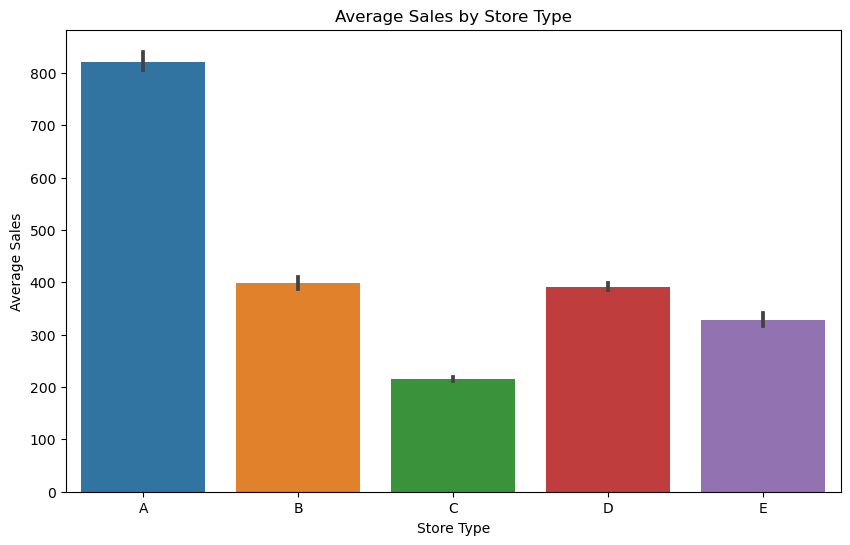

In [52]:
plt.figure(figsize=(10, 6))
sns.barplot(x='type_x_1', y='sales', data=train_df)
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.show()





From the bar plot, we can see that store type A has the highest average sales compared to the other store types in the dataset. This means that, on average, store type A performs better in terms of sales compared to store types B, C, and any other types that might be present in the dataset. It indicates that store type A is potentially the most successful or popular store type in Favorita.

##### To visualize the sales trend over time

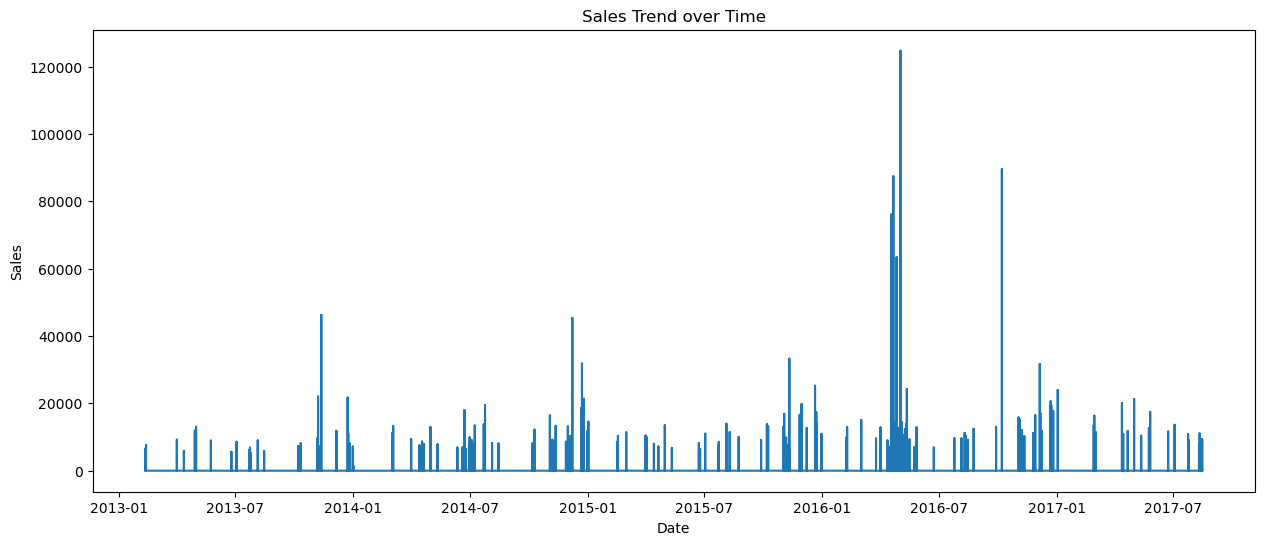

In [95]:
plt.figure(figsize=(15, 6))
plt.plot(train_df.index, train_df['sales'])
plt.title('Sales Trend over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()



We can observe that there is a yearly seasonality in sales where data tend to increase at the beginning of each year and then decrease as the year progresses. This pattern suggests that there might be some seasonal factors influencing the sales behavior, and the sales trend repeats annually.

To further analyze the seasonality pattern and better understand the factors influencing the sales, we can perform seasonal decomposition or use advanced time series analysis techniques like SARIMA (Seasonal AutoRegressive Integrated Moving Average).

Seasonal decomposition can help break down the time series data into its constituent components, such as trend, seasonality, and residuals (random fluctuations). 

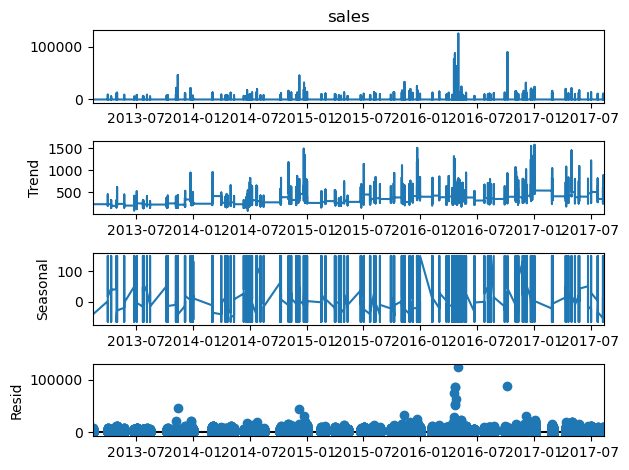

In [98]:
# Perform seasonal decomposition
result = seasonal_decompose(train_df['sales'], model='additive', period=365)

# Plot the decomposed components
result.plot()
plt.show()



The SARIMA visualization reveals a generally upward trending pattern in sales over time, with occasional minor declines that do not significantly impact the overall trend. 
The fully colored seasonal component indicates prominent recurring patterns at fixed intervals, likely due to seasonal factors influencing sales. 
Additionally, the residual component shows mostly random behavior, but with a few outliers suggesting some patterns yet to be fully captured by the model.

In [103]:


# Perform the ADF test
result = adfuller(train_df['sales'])

# Extract the p-value from the test result
p_value = result[1]

# Check for stationarity based on the p-value
if p_value < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")


KeyboardInterrupt: 

##### To compare Sales on Holidays and Non Holidays

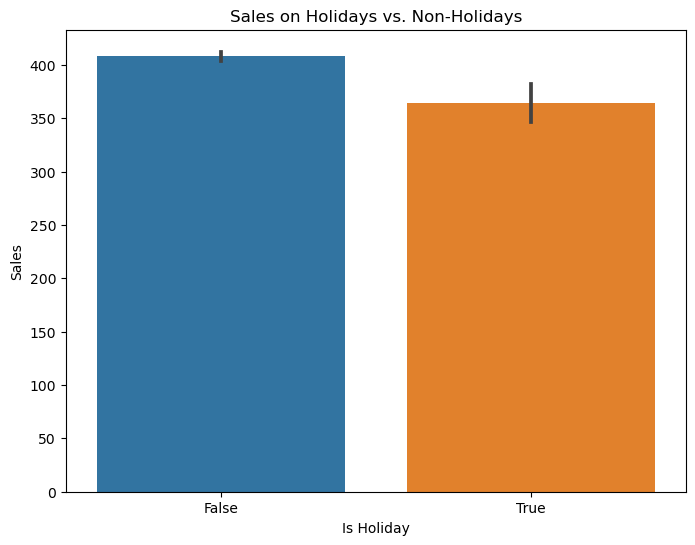

In [57]:
# Bar plot to compare sales on holidays and non-holidays
plt.figure(figsize=(8, 6))
sns.barplot(x='transferred', y='sales', data=train_df)
plt.title('Sales on Holidays vs. Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.show()



The bar plot comparing sales on holidays and non-holidays shows that sales are generally lower on holidays (transferred=True) compared to non-holidays (transferred=False). This suggests that there might be a negative impact on sales during holidays, possibly due to store closures or reduced consumer activity

##### Barplot to show Sales on Holidays By Store Type

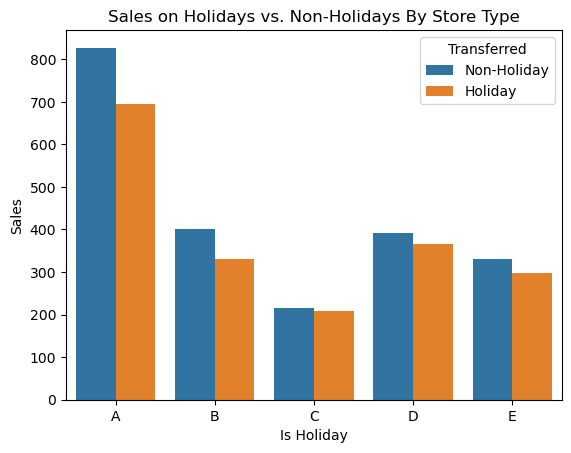

In [58]:
sns.barplot(x='type_x_1', y='sales', hue='transferred', data=train_df, ci=None)
plt.title('Sales on Holidays vs. Non-Holidays By Store Type')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.legend(title='Transferred', labels=['Non-Holiday', 'Holiday'])
plt.show()

The bar plot clearly illustrates that store type A exhibits the highest sales compared to the other store types in the dataset. This observation suggests that, store type A outperforms store types B, C, and any other potential types present in the dataset even on Holidays

##### Compare Sales with Oil prices

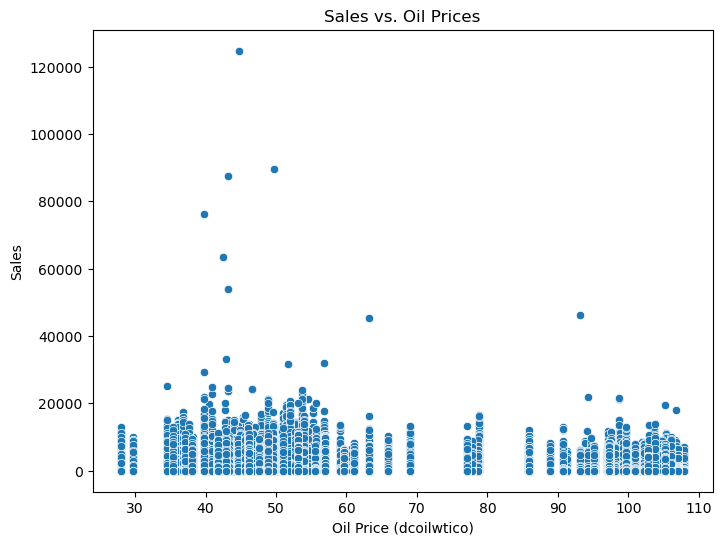

In [59]:
# Scatter plot to compare sales with oil prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dcoilwtico', y='sales', data=train_df)
plt.title('Sales vs. Oil Prices')
plt.xlabel('Oil Price (dcoilwtico)')
plt.ylabel('Sales')
plt.show()


From the scatter plot, we can observe the following:

Distribution: The majority of data points appear to be concentrated around a specific range of oil prices and sales values. 

Relationship: There is a positive relationship between sales and oil prices. As the oil price tends to increase, the sales also tend to increase slightly. However, the relationship is not very strong, as there is a scatter in the data points.

Outliers: There are a few outliers where the sales values are notably higher or lower than the majority of data points. These outliers could represent exceptional cases or specific events that might have influenced sales independently of oil prices.

Oil Price Range: Most of the data points have oil prices within a certain range, indicating that oil prices do not vary significantly across the dataset.

Sales Variation: Sales values vary widely across the dataset, regardless of oil prices. This suggests that there are other factors influencing sales beyond just oil prices.

Overall, the scatter plot helps us visualize the relationship between sales and oil prices. While there seems to be a weak positive association, it's essential to keep in mind that other factors may play a more significant role in influencing sales, and further analysis and modeling are needed to understand the complete picture.

##### Sales Variation with Store Clusters

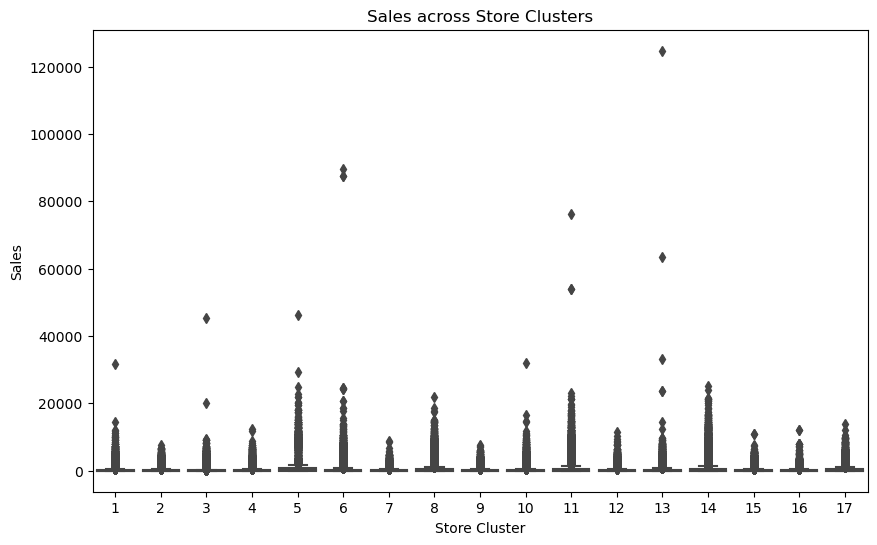

In [60]:
# Box plot to compare sales across store clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='sales', data=train_df)
plt.title('Sales across Store Clusters')
plt.xlabel('Store Cluster')
plt.ylabel('Sales')
plt.show()


The box plot provides a visual comparison of the sales distribution across different store clusters. It helps us understand the variation in sales between different groups of stores. Here are some key observations we can make from the box plot:

Cluster Comparison: By comparing the medians and IQRs of the boxes, we can identify clusters that tend to have higher or lower sales on average.

Outliers: Outliers indicate stores within a cluster that have exceptionally high or low sales compared to the majority of stores in that cluster.

Sales Range: The height of the boxes (IQR) and the length of the whiskers give us an idea of the range of sales values within each cluster.

Cluster Differences: The box plot allows us to identify clusters with significant differences in sales. Some clusters may have a more consistent sales performance, while others may have a wider variation in sales.

##### Sales Variation with On Promotion
We can analyze whether sales are significantly affected by promotional offers. A bar plot can show the average sales for items on promotion and not on promotion.

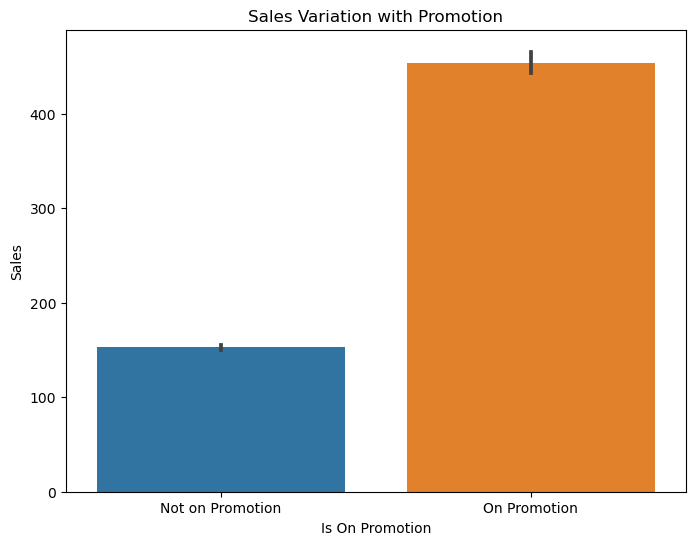

In [61]:
# Map the numeric onpromotion values to meaningful labels
onpromotion_mapping = {0: 'Not on Promotion', 1: 'On Promotion'}
train_df['onpromotion'] = train_df['onpromotion'].map(onpromotion_mapping)

# Create the bar plot with labels
plt.figure(figsize=(8, 6))
sns.barplot(x='onpromotion', y='sales', data=train_df)
plt.title('Sales Variation with Promotion')
plt.xlabel('Is On Promotion')
plt.ylabel('Sales')
plt.show()


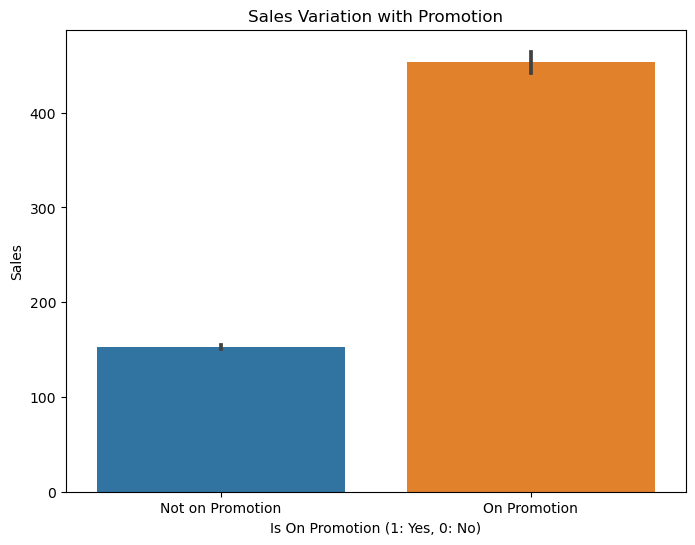

In [62]:
# Create the bar plot to compare sales variation with promotion
plt.figure(figsize=(8, 6))
sns.barplot(x='onpromotion', y='sales', data=train_df)

# Add title and labels for better understanding
plt.title('Sales Variation with Promotion')
plt.xlabel('Is On Promotion (1: Yes, 0: No)')  # Indicates that 1 represents "on promotion" and 0 represents "not on promotion"
plt.ylabel('Sales')

# Display the plot
plt.show()


From the bar plot, we can observe that sales for products that are on promotion are higher compared to products that are not on promotion. The bar corresponding to "On Promotion" is visibly taller than the one corresponding to "Not On Promotion," indicating that the average sales for products with promotions are greater.

### Hypothesis
1. One-Sample T-Test: If we have a specific hypothesis about the average sales of a product family at a particular store, we can use a one-sample t-test. For example, we could test whether the average sales of a product family at a specific store differ significantly from a certain value. 


2. Independent Samples T-Test: If we want to compare the average sales of a product family between two different stores, we can use an independent samples t-test. This test will help determine if there is a significant difference in the average sales of the product family between the two stores. 

 
3. Paired Samples T-Test: If we have data on sales for the same product family at a particular store on different dates, and we want to test if there is a significant difference in sales before and after a promotional period, we can use a paired samples t-test. 

 
4. Chi-Square Test: If we want to examine the relationship between the promotion of a product family (onpromotion column) and the sales outcomes (sales column), we can use a chi-square test. This test can help determine if there is a significant association between the two variables. 

 

These are just a few examples, and the choice of hypothesis test we can generate.  

  THESE ARE THE CODES ASSOCIATED WITH THE HYPOTHESIS WE DEVELOPED.  


#### One-Sample T-Test: is used to determine whether the mean of a sample significantly differs from a specified population mean.

#### NULL HYPOTHESIS :  Average sales of a product family at a specific store is not 500 

#### ALTENATE HYPOTHESIS: Average sales of a product family at a specific store is 500 

In [63]:
# sales_data =  Your sales data for the product family at the specific store 

sales_data = train_df.loc[(train_df['family'] == 'AUTOMOTIVE') & (train_df['store_nbr'] == 1), 'sales']

t_statistic, p_value = stats.ttest_1samp(sales_data, 500)

if p_value < 0.05:
    print("Reject null hypothesis: Average sales are significantly different from 500")
else:
    print("Fail to reject null hypothesis: Average sales are not significantly different from 500")


 

Reject null hypothesis: Average sales are significantly different from 500


#### Independent Samples T-Test: is utilized to compare the means of two independent groups to determine if they are significantly different from each other.

#### NULL HYPOTHESIS: Average sales of product family do not differ between store 1 and store 2


#### ALTENATE HYPOTHESIS: Average sales of product family differ between store 1 and store 2


In [64]:
# Select the sales data for product family at store 1
sales_store1 = train_df.loc[(train_df['family'] == 'YOUR_PRODUCT_FAMILY') & (train_df['store_nbr'] == 1), 'sales']

# Select the sales data for product family at store 2
sales_store2 = train_df.loc[(train_df['family'] == 'YOUR_PRODUCT_FAMILY') & (train_df['store_nbr'] == 2), 'sales']

# Perform the independent samples t-test
t_statistic, p_value = stats.ttest_ind(sales_store1, sales_store2)

if p_value < 0.05:
    print("Reject null hypothesis: Average sales differ significantly between the stores")
else:
    print("Fail to reject null hypothesis: Average sales do not differ significantly between the stores")


Fail to reject null hypothesis: Average sales do not differ significantly between the stores


#### Paired Samples T-Test: A paired samples t-test, also known as a dependent samples t-test, is employed to compare the means of two related groups or variables.

####  NULL HYPOTHESIS: There is no significant difference in sales before and after promotion

####  ALTENATE Hypothesis: There is a significant difference in sales before and after promotion

In [65]:
# Select the sales data for product family before the promotion
sales_before = train_df.loc[(train_df['family'] == 'YOUR_PRODUCT_FAMILY') & (train_df['onpromotion'] == 0), 'sales']

# Select the sales data for product family after the promotion
sales_after = train_df.loc[(train_df['family'] == 'YOUR_PRODUCT_FAMILY') & (train_df['onpromotion'] == 1), 'sales']

# Perform the paired samples t-test
t_statistic, p_value = stats.ttest_rel(sales_before, sales_after)

if p_value < 0.05:
    print("Reject null hypothesis: There is a significant difference in sales before and after promotion")
else:
    print("Fail to reject null hypothesis: There is no significant difference in sales before and after promotion")


Fail to reject null hypothesis: There is no significant difference in sales before and after promotion


#### Chi-Square Test: is a statistical test that assesses the association between two categorical variables.

#### NULL HYPOTHESIS: Promotion and sales outcomes are not associated

#### ALTENATE  Hypothesis: Promotion and sales outcomes are associated

In [66]:

# Select the promotion data for the product family
promotion_data = train_df.loc[train_df['family'] == 'YOUR_PRODUCT_FAMILY', 'onpromotion']

# Select the sales data for the product family
sales_data = train_df.loc[train_df['family'] == 'YOUR_PRODUCT_FAMILY', 'sales']

# Create a contingency table
contingency_table = [
    [sum(promotion_data & (sales_data > 0)), sum((~promotion_data) & (sales_data > 0))],
    [sum(promotion_data & (sales_data == 0)), sum((~promotion_data) & (sales_data == 0))]
]

# Perform the chi-square test of independence
chi2_statistic, p_value, _, _ = stats.chi2_contingency(contingency_table)

if p_value < 0.05:
    print("Reject null hypothesis: Promotion and sales outcomes are associated")
else:
    print("Fail to reject null hypothesis: Promotion and sales outcomes are not associated")


Fail to reject null hypothesis: Promotion and sales outcomes are not associated


### QUESTIONS

#### 1. Which dates have the lowest and highest sales for each year?

In [67]:
# Group the data by year and find the dates with the lowest and highest sales for each year
lowest_sales_dates = train_df.groupby(train_df.index.year)['sales'].idxmin()
highest_sales_dates = train_df.groupby(train_df.index.year)['sales'].idxmax()

# Print the lowest and highest sales dates for each year
for year in train_df.index.year.unique():
    lowest_sales_date = lowest_sales_dates[year]
    highest_sales_date = highest_sales_dates[year]
    print(f"For the year {year}:")
    print(f"Lowest sales date: {lowest_sales_date}")
    print(f"Highest sales date: {highest_sales_date}")
    print()





For the year 2013:
Lowest sales date: 2013-02-11 00:00:00
Highest sales date: 2013-11-12 00:00:00

For the year 2014:
Lowest sales date: 2014-01-01 00:00:00
Highest sales date: 2014-12-08 00:00:00

For the year 2015:
Lowest sales date: 2015-01-01 00:00:00
Highest sales date: 2015-11-11 00:00:00

For the year 2016:
Lowest sales date: 2016-02-08 00:00:00
Highest sales date: 2016-05-02 00:00:00

For the year 2017:
Lowest sales date: 2017-01-02 00:00:00
Highest sales date: 2017-01-02 00:00:00



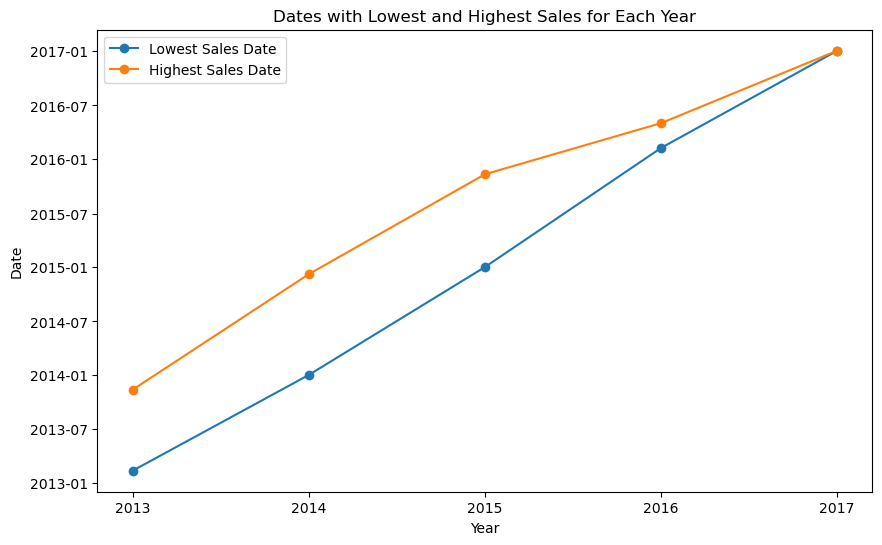

In [68]:
# Group the data by year and find the dates with the lowest and highest sales for each year
lowest_sales_dates = train_df.groupby(train_df.index.year)['sales'].idxmin()
highest_sales_dates = train_df.groupby(train_df.index.year)['sales'].idxmax()

# Plot the lowest and highest sales dates for each year
plt.figure(figsize=(10, 6))
plt.plot(lowest_sales_dates.dt.year, lowest_sales_dates.dt.date, marker='o', label='Lowest Sales Date')
plt.plot(highest_sales_dates.dt.year, highest_sales_dates.dt.date, marker='o', label='Highest Sales Date')
plt.xlabel('Year')
plt.ylabel('Date')
plt.title('Dates with Lowest and Highest Sales for Each Year')
plt.legend()
plt.xticks(train_df.index.year.unique())
plt.show()

##### By examining the plot, you can identify the specific dates that had the lowest and highest sales for each year. The markers for the lowest sales dates and highest sales dates allow you to visually compare and analyze the sales patterns throughout the years. This information can help us identify recurring trends, seasonal variations, or any notable fluctuations in sales performance over time.

#### 2. Are sales affected by promotions, oil prices and holidays?


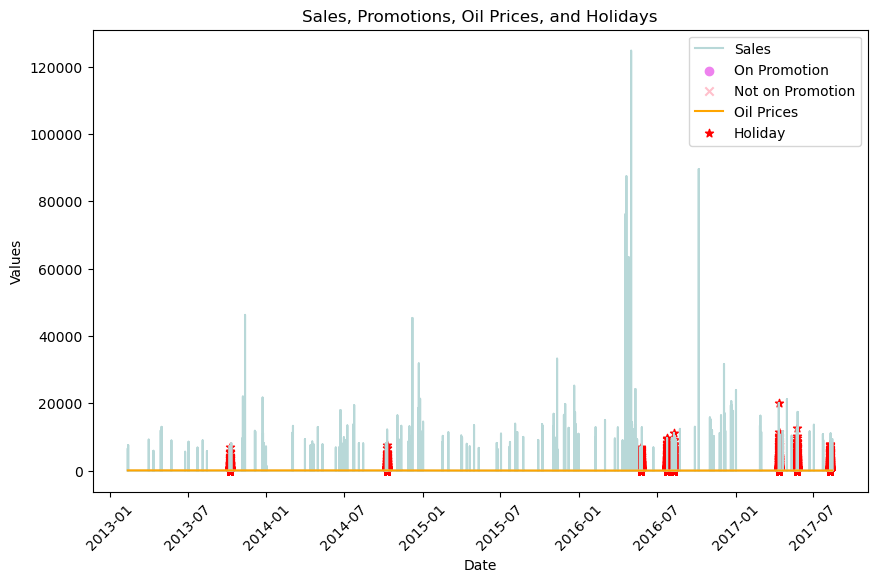

In [69]:
# Sales, Promotions, Oil Prices, and Holidays
plt.figure(figsize=(10, 6))

# Plot sales
plt.plot(train_df.index, train_df['sales'], label='Sales', color='#B8D8D8')  # Soft blue color

# Plot promotions
plt.scatter(train_df.index[train_df['onpromotion'] == 1], train_df['sales'][train_df['onpromotion'] == 1], marker='o', label='On Promotion', color='violet')
plt.scatter(train_df.index[train_df['onpromotion'] == 0], train_df['sales'][train_df['onpromotion'] == 0], marker='x', label='Not on Promotion', color='pink')

# Plot oil prices
plt.plot(train_df.index, train_df['dcoilwtico'], label='Oil Prices', color='orange')

# Plot holidays
plt.scatter(train_df.index[train_df['transferred'] == 1], train_df['sales'][train_df['transferred'] == 1], marker='*', color='red', label='Holiday')

plt.title('Sales, Promotions, Oil Prices, and Holidays')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.show()




##### By observing the visualization, we can draw the following insights:

Sales Trend: The line plot of sales over time shows the overall trend of sales. We can identify any general increasing or decreasing patterns, as well as any significant spikes or drops in sales values.

Promotion Impact: By examining the scatter plot markers for promotions, we can assess if there is a relationship between promotional offers and sales. If the "On Promotion" markers align with higher sales values or clusters, it suggests that promotions may positively influence sales. Conversely, if there is no noticeable difference between "On Promotion" and "Not on Promotion" markers, it indicates that promotions may have limited impact on sales.

Oil Price Influence: The line plot of oil prices allows us to determine if there is any correlation or trend between oil prices and sales. If we observe similar patterns or movements between the two variables, it suggests that oil prices may influence sales behavior.

Holiday Effect: The scatter plot markers for holidays help identify any distinct sales patterns during holiday periods. If we notice significant changes in sales values during holidays compared to non-holiday days, it indicates that holidays may impact consumer behavior and subsequently affect sales.

Overall, the visualization allows us to visually explore and analyze the relationships between sales, promotions, oil prices, and holidays. It helps us gain insights into the potential impact of these factors on sales performance and identify any notable patterns or trends.

#### 3. Did the earthquake impact sales?

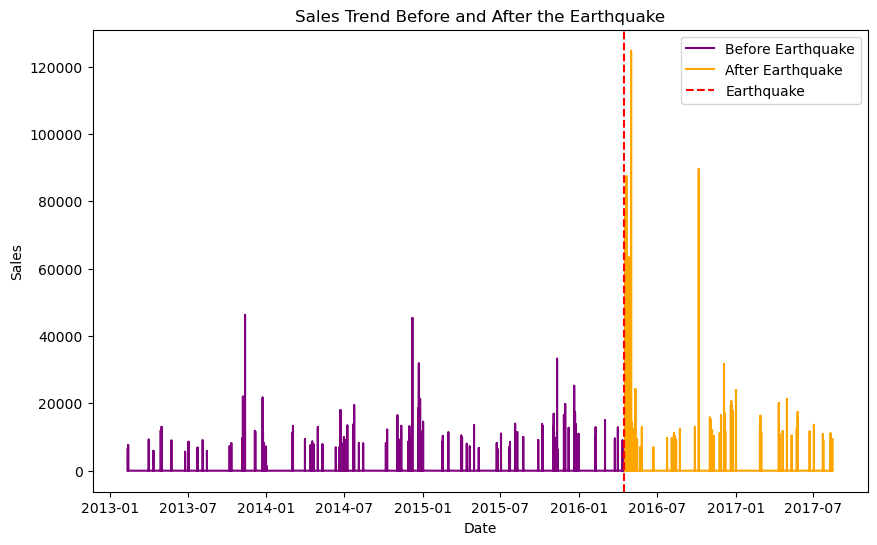

In [99]:
# Filter the data for the period before and after the earthquake
before_earthquake_df = train_df[train_df.index < '2016-04-16']
after_earthquake_df = train_df[train_df.index >= '2016-04-16']

# Visualize the impact of the earthquake on sales

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(before_earthquake_df.index, before_earthquake_df['sales'], color='purple', label='Before Earthquake')
plt.plot(after_earthquake_df.index, after_earthquake_df['sales'], color='orange', label='After Earthquake')
plt.axvline(x='2016-04-16', color='red', linestyle='--', label='Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Before and After the Earthquake')
plt.legend()
plt.show()


##### To analyze the impact of the earthquake on sales, we can compare the sales trend before and after the earthquake. The line plot visualizes this comparison.

##### In the plot, the purple line represents the sales trend before the earthquake, while the orange line represents the sales trend after the earthquake. The x-axis shows the dates, and the y-axis represents the sales values.

##### If there is a noticeable change in the sales trend or a significant deviation in sales values after the earthquake (compared to the trend before the earthquake), it suggests that the earthquake might have impacted sales.

##### By examining the plot, we can observe whether the sales trend or the sales values show any abrupt changes or deviations around the date of the earthquake, marked by the vertical red dashed line. If there is a significant shift in the sales pattern after the earthquake, it indicates that the earthquake had an impact on sales.

##### Therefore, based on the line plot, we can visually assess whether the earthquake had an impact on sales by comparing the sales trend before and after the earthquake.

#### 4. What analysis can we get from the date and its extractable features?

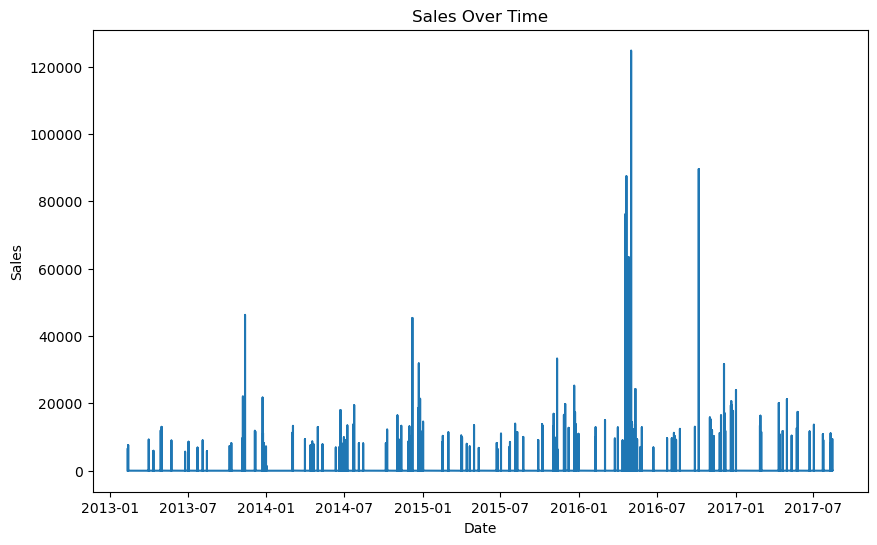

In [71]:
# Time series plot
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.show()



##### The time series plot visualizes the sales data over time and helps answer the question of how sales have evolved throughout the given time period. The x-axis represents the dates, and the y-axis represents the sales values.

##### By examining the plot, we can observe the following:

##### Trend: The plot shows the overall trend in sales over time. We can identify whether sales have been increasing, decreasing, or remaining relatively stable. This information can help us understand the general direction and magnitude of sales changes.

##### Seasonality: If there is a repeating pattern or seasonality in the sales data, it will be visible in the plot. For example, if sales tend to increase during certain months or seasons and decrease during others, we can identify these patterns from the plot.

##### Fluctuations: The plot displays the fluctuations or variations in sales over time. This can help us identify any irregular or unexpected changes in sales and investigate the potential factors contributing to these fluctuations.

###### Outliers: Any exceptional or outlier sales data points will be visible on the plot. These outliers may indicate special events, promotions, or other factors that significantly impacted sales during specific time periods.

##### By examining the time series plot, we can gain insights into the overall sales performance, identify sales trends, and potentially discover patterns or events that affected sales throughout the given time period.

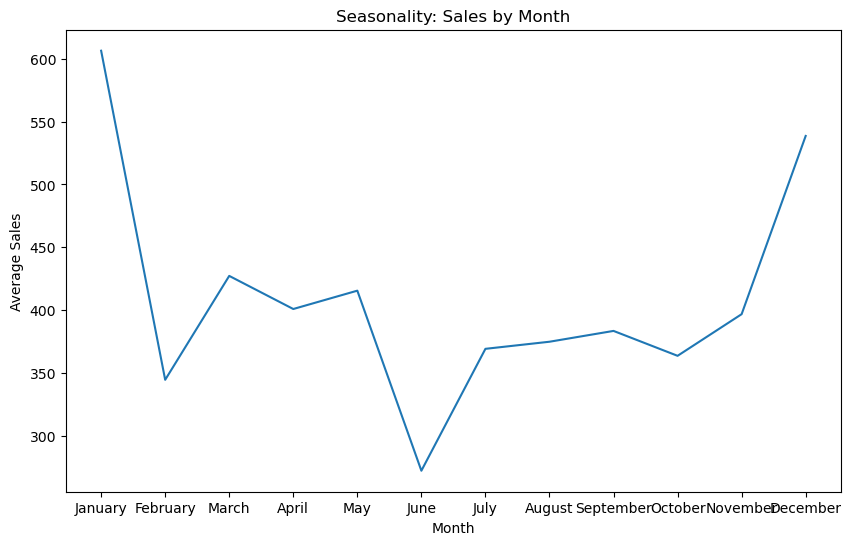

In [72]:
# Group the data by month and calculate the average sales
monthly_sales = train_df.groupby(train_df.index.month)['sales'].mean()

# Get the month names
month_names = [calendar.month_name[i] for i in monthly_sales.index]

# Plot the average sales by month
plt.figure(figsize=(10, 6))
plt.plot(month_names, monthly_sales)
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Seasonality: Sales by Month')
plt.show()

##### The seasonality analysis plot shows the average sales for each month, allowing us to identify any recurring patterns or trends in sales behavior throughout the year. The x-axis represents the months, and the y-axis represents the average sales.

By examining the plot, we can make the following observations:

Seasonal Patterns: The plot helps us identify any regular or cyclical patterns in sales over the months. For example, if we see a consistent increase or decrease in sales during certain months, it suggests that sales are influenced by seasonal factors.

Peak Months: Peaks in the plot indicate the months with the highest average sales. These months are likely to be influenced by factors such as holidays, special events, or seasonal demand for specific products.

Trough Months: Troughs in the plot represent the months with the lowest average sales. These months may experience lower consumer demand or other factors that affect sales negatively.

Sales Variations: The plot allows us to compare the average sales across different months. If we observe significant variations between months, it indicates that sales performance fluctuates throughout the year.

Overall, the seasonality analysis plot helps us understand the monthly sales patterns and identify the months with the highest and lowest average sales. This information is valuable for understanding the impact of seasonality on sales forecasting, planning promotions, and making informed business decisions.

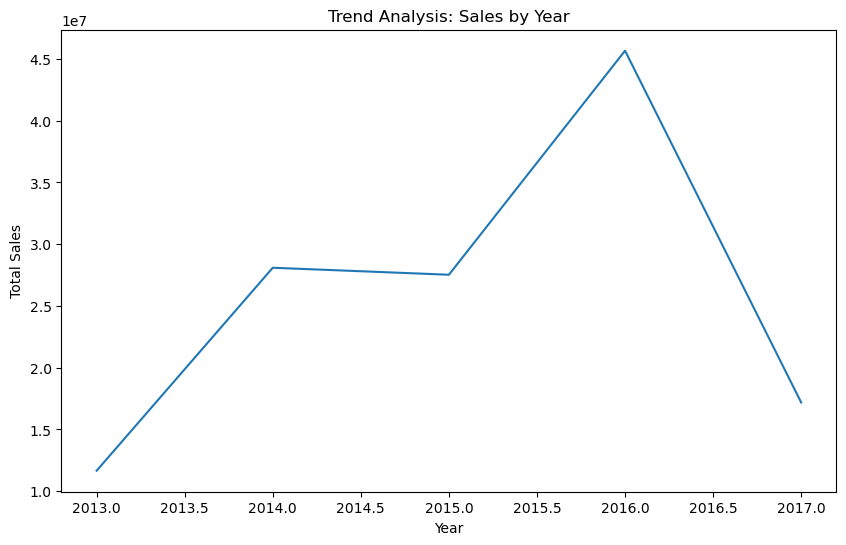

In [73]:
# Trend Analysis - Sales by Year
yearly_sales = train_df.groupby(train_df.index.year)['sales'].sum()
plt.figure(figsize=(10, 6))
plt.plot(yearly_sales.index, yearly_sales)
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Trend Analysis: Sales by Year')
plt.show()

##### This helps to identify any patterns or trends in sales over the years, enabling us to understand the overall direction and magnitude of sales growth or decline.


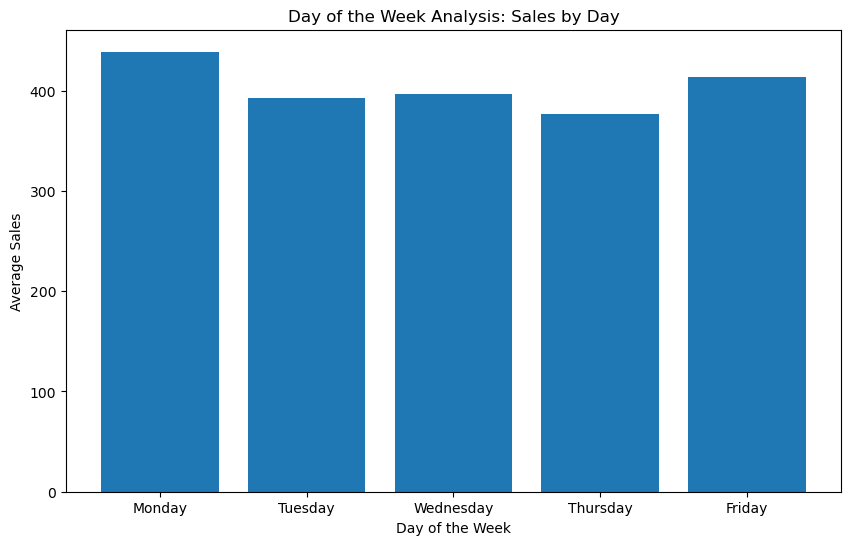

In [74]:
#Day of the Week Analysis - Sales by Day
daily_sales = train_df.groupby(train_df.index.dayofweek)['sales'].mean()
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10, 6))
plt.bar(day_labels[:len(daily_sales)], daily_sales)
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.title('Day of the Week Analysis: Sales by Day')
plt.show()





##### This visualization allows us to identify any weekly patterns or trends in sales and determine if there are specific days that consistently have higher or lower sales.
By visualizing the average sales by day of the week, we can analyze the patterns and variations in sales across different days. This information can help identify trends and insights, such as which days tend to have higher or lower sales, and inform decision-making related to inventory management, staffing, and promotional strategies.

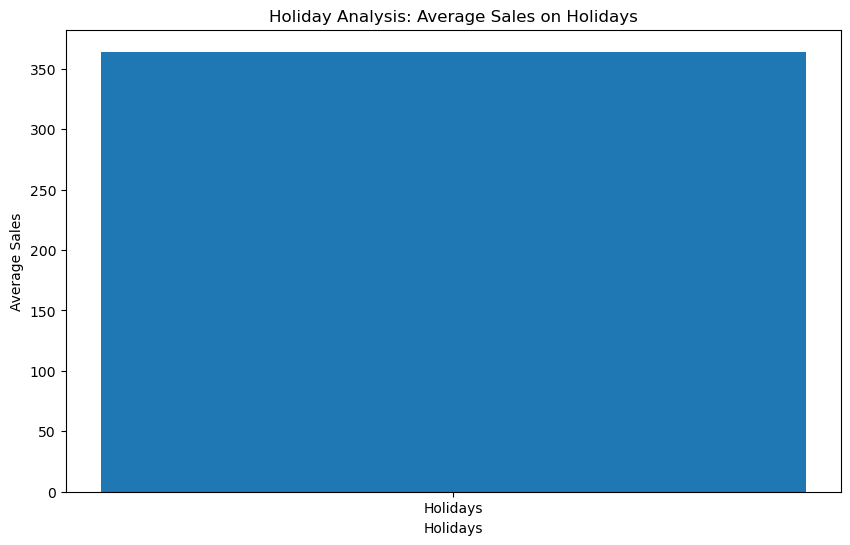

In [76]:
# Filter the data for holidays
holiday_sales = train_df[train_df['transferred'] == 1]['sales']

# Calculate the average sales on holidays
average_sales = holiday_sales.mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar('Holidays', average_sales)
plt.xlabel('Holidays')
plt.ylabel('Average Sales')
plt.title('Holiday Analysis: Average Sales on Holidays')
plt.show()





##### This visualization allows you to compare the average sales on holidays, providing insights into the impact of holidays on sales performance.

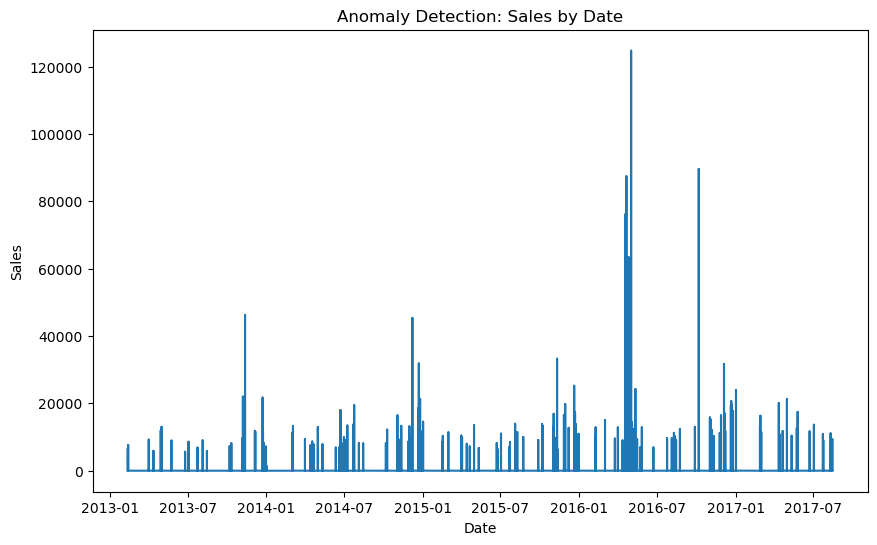

In [77]:
# Anomaly Detection - Sales by Date
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Anomaly Detection: Sales by Date')
plt.show()


#### This visualization helps in detecting any unusual patterns, spikes, or dips in the sales data, which could indicate anomalies or outliers. It allows for a visual examination of the sales data over time and can be helpful in identifying any irregularities in the sales patterns.

#### Question 5 Are certain groups of stores selling more products? (Cluster, city, state, type)

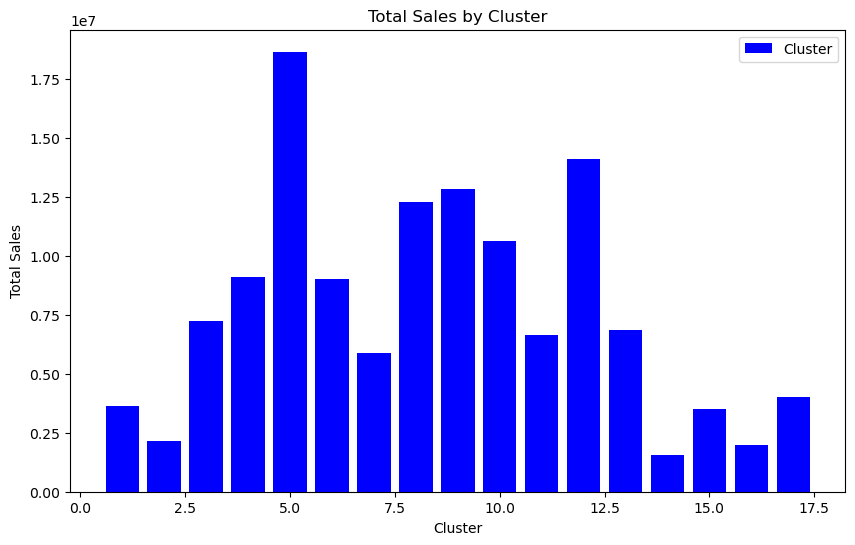

In [79]:
# Calculate the total sales for each group
sales_by_cluster = train_df.groupby('cluster')['sales'].sum()
sales_by_city = train_df.groupby('city')['sales'].sum()
sales_by_state = train_df.groupby('state')['sales'].sum()
sales_by_type = train_df.groupby('type_x_1')['sales'].sum()

# Get the cluster names
cluster_names = train_df['cluster'].unique()

# Plot the total sales for cluster
plt.figure(figsize=(10, 6))
plt.bar(cluster_names, sales_by_cluster.values, label='Cluster', color='blue')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.title('Total Sales by Cluster')
plt.legend()
plt.show()








##### This visualization helps in comparing the total sales across different clusters, providing insights into the sales performance of each cluster. It allows for a quick comparison and identification of clusters with higher or lower sales.

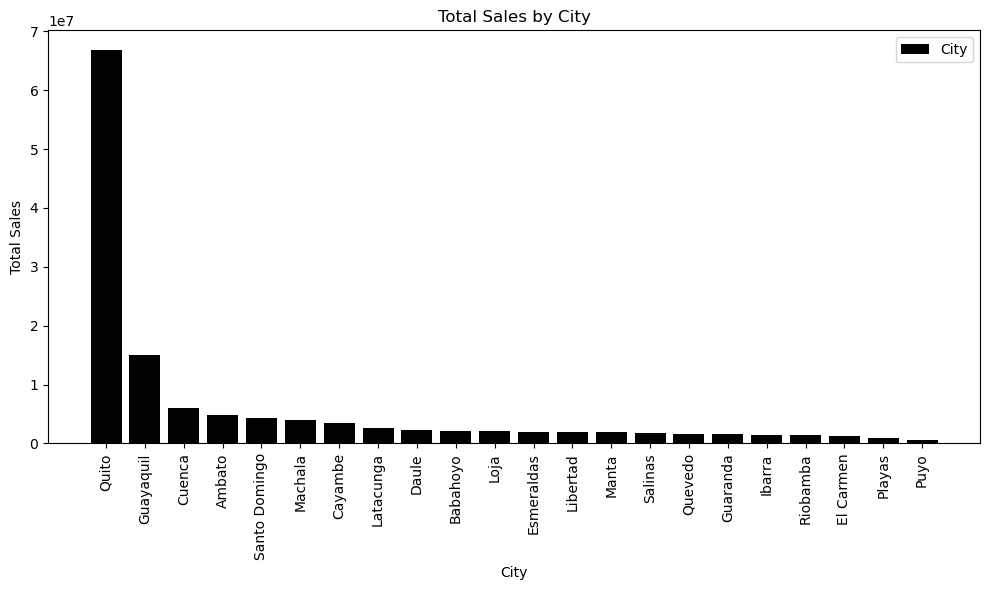

In [80]:
# Sort the sales by city in descending order
sales_by_city_sorted = sales_by_city.sort_values(ascending=False)

# Plot the total sales for each city
plt.figure(figsize=(10, 6))
plt.bar(sales_by_city_sorted.index, sales_by_city_sorted.values, label='City', color='black')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.title('Total Sales by City')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



##### The plot above shows that Quito has the highest sales with Puyo having the lowest.

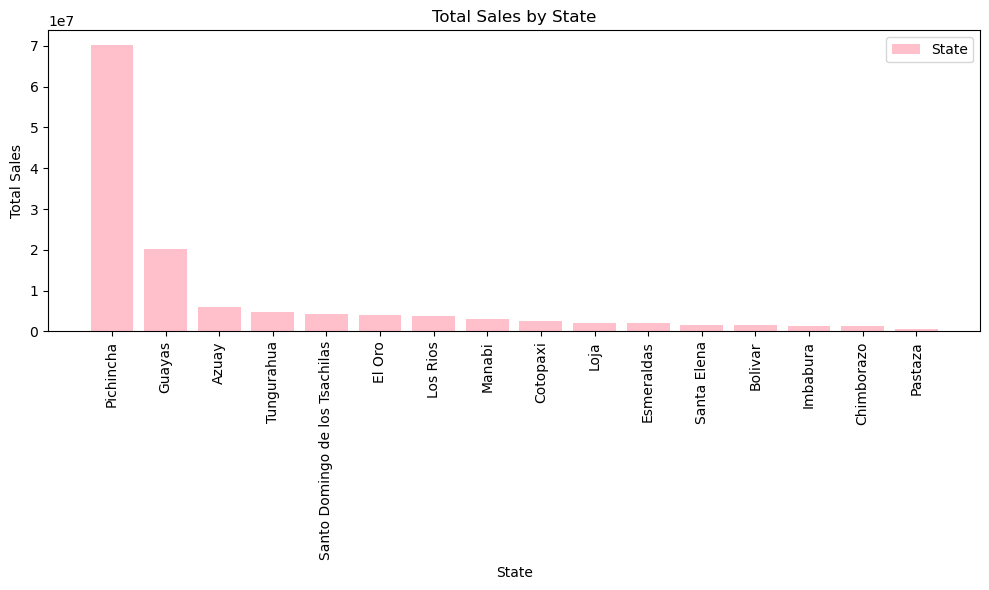

In [81]:
plt.figure(figsize=(10, 6))
sales_by_state = train_df.groupby('state')['sales'].sum()
sales_by_state_sorted = sales_by_state.sort_values(ascending=False)
plt.bar(sales_by_state_sorted.index, sales_by_state_sorted.values, label='State', color='pink')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.title('Total Sales by State')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


##### This visualization helps identify states that contribute significantly to the total sales and those with comparatively lower sales.

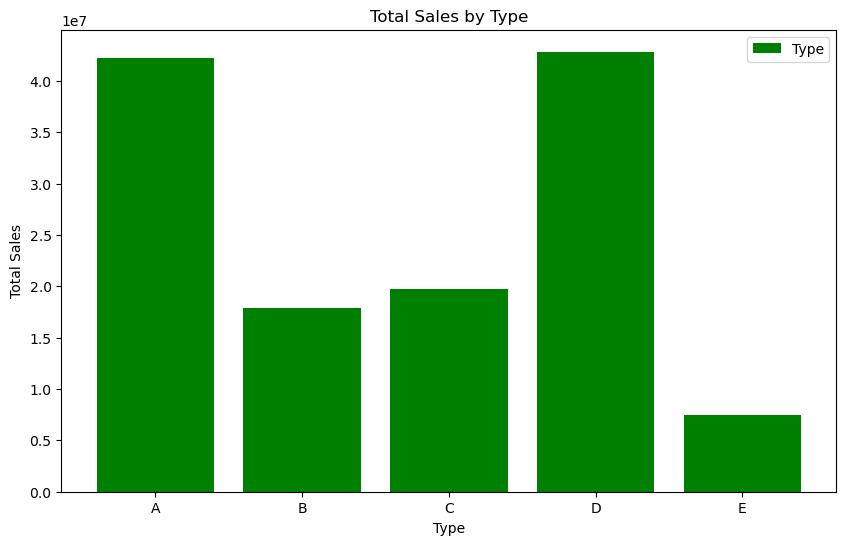

In [82]:
plt.figure(figsize=(10, 6))
plt.bar(sales_by_type.index, sales_by_type.values, label='Type', color='green')
plt.xlabel('Type')
plt.ylabel('Total Sales')
plt.title('Total Sales by Type')
plt.legend()
plt.show()


#### Export Dataframe for Power BI visualization

##### This visualization is valuable for understanding the sales performance of different store types and identifying any patterns or discrepancies

In [83]:
# Export train_df as Excel
#train_df.to_excel('train_data.xlsx', index=True)


### Feature Engineering 

##### The code train_df['lag_1'] = train_df['sales'].shift(1) creates a new column called 'lag_1' in the train_df DataFrame. It assigns the values of the 'sales' column shifted by 1 position to the 'lag_1' column.

##### In other words, for each row in the DataFrame, the value in the 'lag_1' column will be the 'sales' value from the previous row. This introduces a lag of 1 day in the 'sales' data.

##### Similarly, the code train_df['lag_7'] = train_df['sales'].shift(7) creates another column called 'lag_7' and assigns the values of the 'sales' column shifted by 7 positions to the 'lag_7' column. This introduces a lag of 7 days in the 'sales' data.

##### Lagged features are useful in time series analysis as they capture the relationship between the current observation and past observations. By including lagged features in the dataset, we can consider the influence of previous values on the current value and potentially improve the accuracy of forecasting models.


In [104]:
# Lagged Features
train_df['lag_1'] = train_df['sales'].shift(1)
train_df['lag_7'] = train_df['sales'].shift(7)

##### Rolling statistics, also known as moving statistics or rolling averages, are calculated by taking a sliding window of a specified size and calculating summary statistics within that window. In this case, we are calculating the rolling mean and rolling standard deviation.

##### Rolling Mean: The rolling mean, also known as the moving average, is calculated by taking the average of the values within a sliding window. In the code, we calculate the rolling mean with a window size of 7, meaning that for each data point, we take the average of the sales values in the current day and the previous 6 days. The rolling mean provides a smoothed representation of the data by reducing the impact of short-term fluctuations and highlighting the underlying trend.

##### Rolling Standard Deviation: The rolling standard deviation measures the variability or dispersion of the values within a sliding window. It is calculated by taking the standard deviation of the values within the window. Similar to the rolling mean, the rolling standard deviation is calculated with a window size of 7 in the code. The rolling standard deviation helps us understand the volatility or variability of the sales values over time.

##### By calculating rolling statistics such as the rolling mean and rolling standard deviation, we can gain insights into the trend, seasonality, and variability of the time series data. These statistics can be useful in identifying patterns, detecting anomalies, and making informed decisions.

In [105]:
# Rolling Statistics
train_df['rolling_mean_7'] = train_df['sales'].rolling(window=7).mean()
train_df['rolling_std_7'] = train_df['sales'].rolling(window=7).std()

### Training and Testing

In [106]:
#Train-Test Split
train_size = int(len(train_df) * 0.8)  # 80% for training, 20% for testing
train_data = train_df[:train_size]
test_data = train_df[train_size:]

In [121]:
model = SARIMAX(train_data['sales'], order=(1, 0, 0), seasonal_order=(1, 0, 0, 7))
model_fit = model.fit()



start_date = test_data.index[0]
end_date = test_data.index[-1]

predictions = model_fit.predict(start=start_date, end=end_date)



In [119]:
test_data.reset_index(drop=True, inplace=True)




In [127]:
# Model Prediction
# Evaluate the performance of the model on the testing set
mse = mean_squared_error(test_data['sales'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['sales'], predictions)

Mean Squared Error (MSE): 2380219.5086881453
Root Mean Squared Error (RMSE): 1542.7960035883375
Mean Absolute Error (MAE): 521.8145800108857


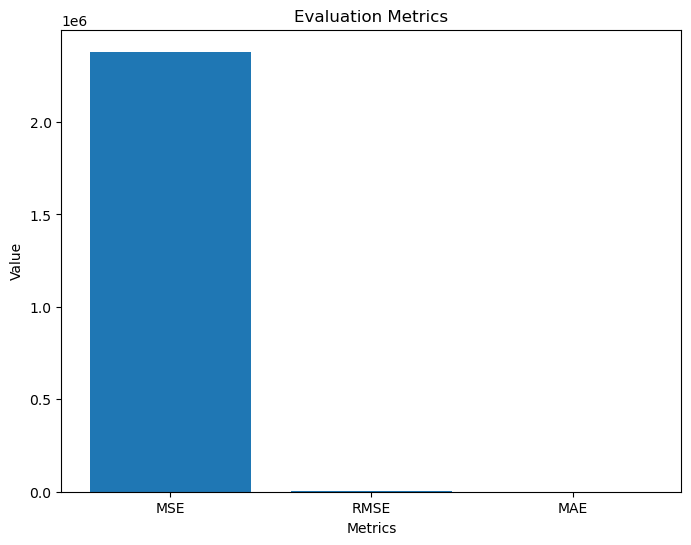

In [130]:
# Define the evaluation metrics
metrics = ['MSE', 'RMSE', 'MAE']
values = [mse, rmse, mae]

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Evaluation Metrics')
plt.show()

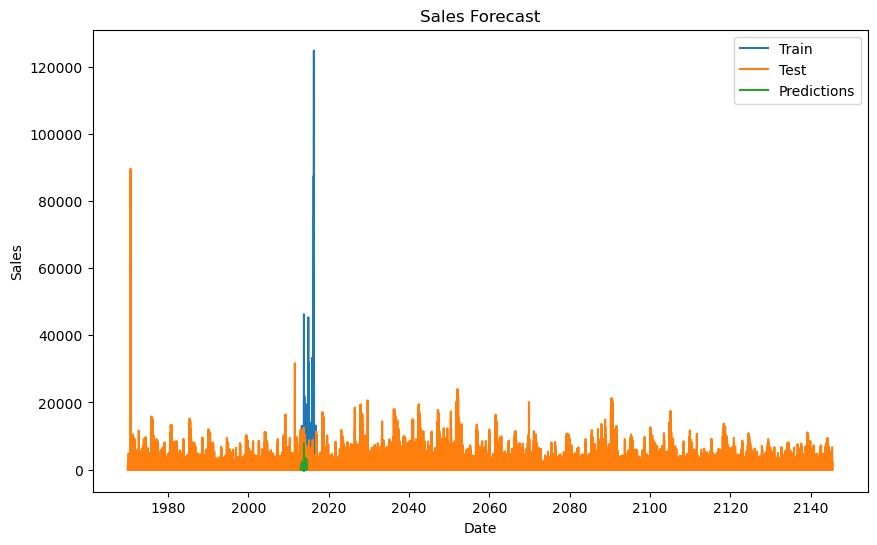

In [128]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['sales'], label='Train')
plt.plot(test_data.index, test_data['sales'], label='Test')
plt.plot(predictions.index, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast')
plt.legend()
plt.show()

In [134]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare the data
# Assuming you have a single time series variable 'sales'
train_data = np.array(train_df['sales'])
test_data = np.array(test_df['sales'])

# Normalize the data
train_mean = np.mean(train_data)
train_std = np.std(train_data)
train_data = (train_data - train_mean) / train_std

# Define the input and output sequences
input_sequence = train_data[:-1]  # Input sequence (all values except the last one)
output_sequence = train_data[1:]  # Output sequence (all values except the first one)

# Reshape the input and output sequences
input_sequence = np.reshape(input_sequence, (len(input_sequence), 1, 1))
output_sequence = np.reshape(output_sequence, (len(output_sequence), 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(1, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(input_sequence, output_sequence, epochs=10, batch_size=1)

# Forecast on the test data
# Assuming you have a single time step ahead to forecast
forecast_input = np.array(test_data[:-1])
forecast_input = np.reshape(forecast_input, (len(forecast_input), 1, 1))
predictions = model.predict(forecast_input)
predictions = predictions.flatten() * train_std + train_mean

# Evaluate the performance of the model
mse = mean_squared_error(test_data[1:], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data[1:], predictions)

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(test_df.index[1:], test_data[1:], label='Actual')
plt.plot(test_df.index[1:], predictions, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast using LSTM')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'tensorflow'